### 思路
1. 数据处理，构造数据集
    - 文本：选max_vocab常见word、K个常见ans
    - 图像：
- 模型
    - image：缩放->cnn->fc_1024
    - question：embeddin->rnn->fc_1024
    - concat or add->fc_K->softmax_K->交叉熵？


In [1]:
from time import time
import json
with open('./dataset/mscoco_val2014_annotations.json') as f1, open('./dataset/MultipleChoice_mscoco_val2014_questions.json') as f2:
    annotations = json.load(f1)
    questions = json.load(f2) 

# with open('./dataset/v2_mscoco_val2014_annotations.json') as f1, open('./dataset/v2_OpenEnded_mscoco_val2014_questions.json') as f2:
#     annotations = json.load(f1)
#     questions = json.load(f2) 
# with open('./dataset/OpenEnded_mscoco_val2014_questions.json') as f:
#     question = json.load(f)


[解析JSON](https://python3-cookbook.readthedocs.io/zh_CN/latest/c06/p02_read-write_json_data.html)，先观察数据

官方API中vqaTools demo：

In [2]:
from vqaTool import VQA
import random
import skimage.io as io
import matplotlib.pyplot as plt
import os

dataDir		='./dataset'
versionType ='' # this should be '' when using VQA v2.0 dataset
taskType    ='MultipleChoice' # 'OpenEnded' only for v2.0. 'OpenEnded' or 'MultipleChoice' for v1.0
dataType    ='mscoco'  # 'mscoco' only for v1.0. 'mscoco' for real and 'abstract_v002' for abstract for v1.0.
dataSubType ='val2014'
annFile     ='%s/%s%s_%s_annotations.json'%(dataDir, versionType, dataType, dataSubType)
quesFile    ='%s/%s%s_%s_%s_questions.json'%(dataDir, versionType, taskType, dataType, dataSubType)
# imgDir 		= '%s/Images/%s/%s/' %(dataDir, dataType, dataSubType)
img_dir = '%s/Images/%s/' %(dataDir, dataSubType)

# initialize VQA api for QA annotations
vqa=VQA(annFile, quesFile)

# load and display QA annotations for given question types
"""
All possible quesTypes for abstract and mscoco has been provided in respective text files in ../QuestionTypes/ folder.
"""
# annIds = vqa.getQuesIds(quesTypes='how many');   
# anns = vqa.loadQA(annIds)
# randomAnn = random.choice(anns)
# vqa.showQA([randomAnn])
# imgId = randomAnn['image_id']
# imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
# if os.path.isfile(imgDir + imgFilename):
# 	I = io.imread(imgDir + imgFilename)
# 	plt.imshow(I)
# 	plt.axis('off')
# 	plt.show()

# load and display QA annotations for given answer types
"""
ansTypes can be one of the following
yes/no
number
other
"""
# annIds = vqa.getQuesIds(ansTypes='yes/no');   
# anns = vqa.loadQA(annIds)
# randomAnn = random.choice(anns)
# vqa.showQA([randomAnn])
# imgId = randomAnn['image_id']
# imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
# if os.path.isfile(imgDir + imgFilename):
# 	I = io.imread(imgDir + imgFilename)
# 	plt.imshow(I)
# 	plt.axis('off')
# 	plt.show()

# load and display QA annotations for given images
"""
Usage: vqa.getImgIds(quesIds=[], quesTypes=[], ansTypes=[])
Above method can be used to retrieve imageIds for given question Ids or given question types or given answer types.
"""
# ids = vqa.getImgIds()
# print(len(ids))


# annIds = vqa.getQuesIds(imgIds=random.sample(ids,5))
# print('id',annIds)
# anns = vqa.loadQA(annIds)
# randomAnn = random.choice(anns)
# vqa.showQA([randomAnn])  
# imgId = randomAnn['image_id']
# imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
# if os.path.isfile(imgDir + imgFilename):
# 	I = io.imread(imgDir + imgFilename)
# 	plt.imshow(I)
# 	plt.axis('off')
# 	plt.show()

loading VQA annotations and questions into memory...
0:00:02.500054
creating index...
index created!


'\nUsage: vqa.getImgIds(quesIds=[], quesTypes=[], ansTypes=[])\nAbove method can be used to retrieve imageIds for given question Ids or given question types or given answer types.\n'

In [3]:
ann = annotations['annotations'][:]
ques = questions['questions'][:]
print(len(ann), len(ques))

QUES_N = len(ques) #
ANS_K = 1000 #最常见的ans数

121512 121512


In [4]:
display(ann[5])
print()
display(ques[5])

{'answer_type': 'other',
 'answers': [{'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 8647,
 'multiple_choice_answer': 'tree',
 'question_id': 86471,
 'question_type': 'what is in the'}

{'image_id': 8647,
 'multiple_choices': ['red',
  '4',
  '2',
  '1',
  'berries and cake',
  'light',
  'no',
  'sun',
  'white',
  'yes',
  'green',
  '1.50',
  'mayonnaise',
  '3',
  'blue',
  'tree',
  'stamp',
  'on feet'],
 'question': 'What is in the top right corner?',
 'question_id': 86471}

### 构造数据集
做完基本处理后放dataloader里，可以并行  
**（1）处理文本**

In [5]:
#提取ques ans imgId
ground_truth_trainset = []
ques_trainset = []
img_ids = []

for i in range(QUES_N):
    ground_truth_trainset.append(ann[i]['multiple_choice_answer'])
    ques_trainset.append(ques[i]['question'])
    if i % 3 == 0:
        img_ids.append(ques[i]['image_id'])
print(len(img_ids))
print(ground_truth_trainset[:3], ques_trainset[:3], img_ids[:1], sep='\n\n')

40504
['wood', 'no', 'kettles']

['What is the table made of?', 'Is the food napping on the table?', 'What has been upcycled to make lights?']

[350623]


In [6]:
# import spacy
# nlp = spacy.load('en')
# return nlp.tokenizer(text)
from collections import Counter
import torch

def word_tokenize(text):
    t = [w for w in text.split(' ')]
    t[-1] = t[-1][:-1]
    return t

word2idx = {'UNK':0}
v = 1
#
for i in range(QUES_N):
    for w in word_tokenize(ques_trainset[i]):
        if w not in word2idx:
            word2idx[w] = v
            v += 1
    ques_trainset[i] = torch.IntTensor([word2idx[w] for w in word_tokenize(ques_trainset[i])])

for i,w in enumerate(ground_truth_trainset):
    if w not in word2idx:
        word2idx[w] = v
        v += 1
    ground_truth_trainset[i] =torch.IntTensor([word2idx[w]])
print('vocab_size:',v)
idx2word = {i:w for i,w in enumerate(word2idx)}
ans_words = dict(Counter(ground_truth_trainset).most_common(ANS_K))#最常见的1000个ans作分类

vocab_size: 19796


** （2）处理图像 **

350623 torch.Size([3, 256, 256])


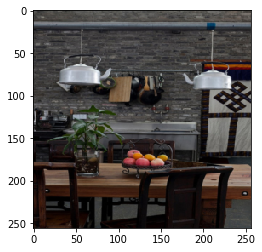

8647 torch.Size([3, 256, 256])


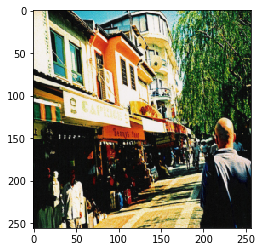

0.40156078338623047


In [7]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

img_size = 256

def trans_img(path, size=img_size):
    mode = Image.open(path)
    if len(mode.split()) == 3:
        transform1 = transforms.Compose([
            transforms.Resize((size, size)),#确保无黑边
            transforms.CenterCrop((size, size)),
            transforms.ToTensor()
        ])
    else:
        transform1 = transforms.Compose([
            transforms.Resize((size, size)),#确保无黑边
            transforms.CenterCrop((size, size)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor()
        ])
    mode = transform1(mode)
    return mode

def show_img(image):
    mode = transforms.ToPILImage()(image)
    plt.imshow(mode)
    plt.show()
    
a = time()
for img_id in img_ids[:2]:
    img_filename = 'COCO_' + dataSubType + '_'+ str(img_id).zfill(12) + '.jpg'
    img = trans_img(img_dir + img_filename)
    print(img_id, img.shape)
    show_img(img)
print(time()-a)

**（3）DataLoader**

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

BATCH_SIZE = 2
MAX_SEQ_LEN = 10

class VQA_Dataset(Dataset):
    def __init__(self, img_ids, q, a):
        self.img_ids = img_ids
        self.q = q            
        self.a = a
        
    def __len__(self):
        return QUES_N
    
    def __getitem__(self, idx):
        img_filename = 'COCO_' + dataSubType + '_'+ str(img_ids[idx//3]).zfill(12) + '.jpg'
        img = trans_img(img_dir + img_filename)
        Lq = len(self.q[idx])
        if Lq > MAX_SEQ_LEN:
            self.q[idx] = self.q[idx][:MAX_SEQ_LEN]
        elif Lq < MAX_SEQ_LEN:
            self.q[idx] = F.pad(self.q[idx], (0,MAX_SEQ_LEN-Lq))#前后分别补多少
        return img, self.q[idx], self.a[idx]
    
dataset = VQA_Dataset(img_ids=img_ids, q=ques_trainset, a=ground_truth_trainset)
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=False, num_workers=40)
# return list[img,q,a], img:[b,3,256,256], q:[b,]

In [ ]:
a = time()
for i,x in enumerate(dataloader):
#     print(x[1])
    pass
print(time()-a)

### VQA model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import numpy as np

SEED = 1234
USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    torch.cuda.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
class VQA_baseline(nn.Module):
    def __init__(self):
        super(VQA_baseline, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 10, 5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.img_fc = nn.Linear(in_features=10*61*61, out_features=1024)
        
#         self.embed
#         self.ques_fc
    
    def forward(self, p):
        #pic:[b,3,256,256], ques:[b,]
        p = self.pool(F.relu(self.conv1(p))) #[b,6,252,252]->[b,6,126,126]
        p = self.pool(F.relu(self.conv2(p))) #[b,10,122,122]->[b,10,61,61]
        p = p.view(-1, 10*61*61) #[b,10*61*61]
        p = self.img_fc(p) #[b,1024]
        return p
        
vqa = VQA_baseline()
vqa(img.unsqueeze(0))